
Design 1: n=36, Diameter=6.1, Density=18
Grid Search               | t = 0.043061 | α = 0.292507
Random Search             | t = 0.044354 | α = 0.302278
Simulated Annealing       | t = 0.042724 | α = 0.290000
Differential Evolution    | t = 0.042784 | α = 0.290446
Nelder-Mead               | t = 0.042813 | α = 0.290658
SLSQP                     | t = 0.042724 | α = 0.290000


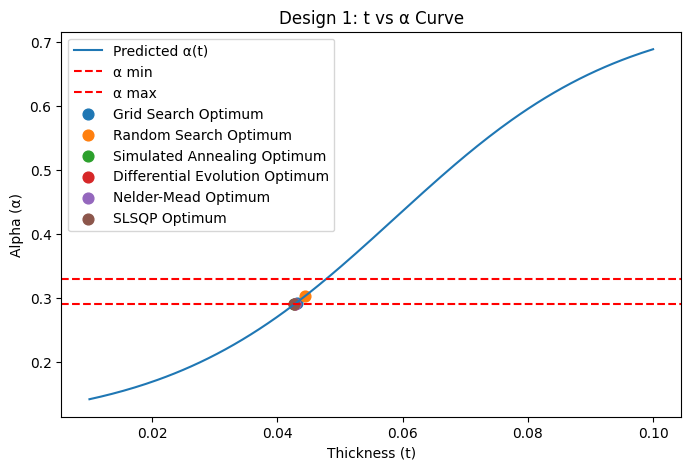

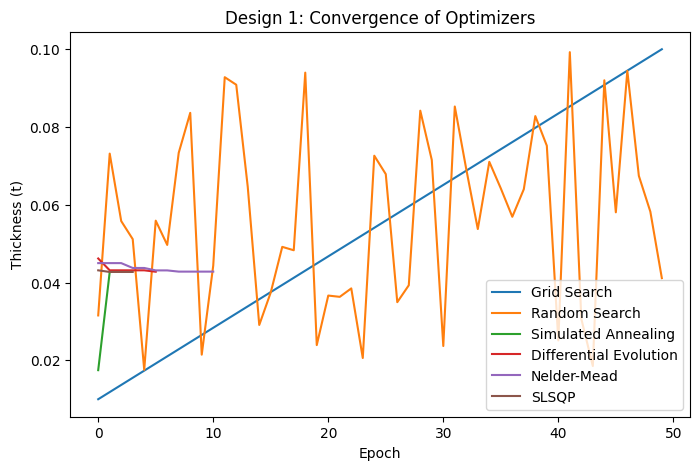


Design 2: n=40, Diameter=9.35, Density=25
Grid Search               | t = 0.037551 | α = 0.293720
Random Search             | t = 0.037257 | α = 0.291529
Simulated Annealing       | t = 0.039969 | α = 0.312279
Differential Evolution    | t = 0.037060 | α = 0.290065
Nelder-Mead               | t = 0.037188 | α = 0.291012
SLSQP                     | t = 0.037051 | α = 0.290000


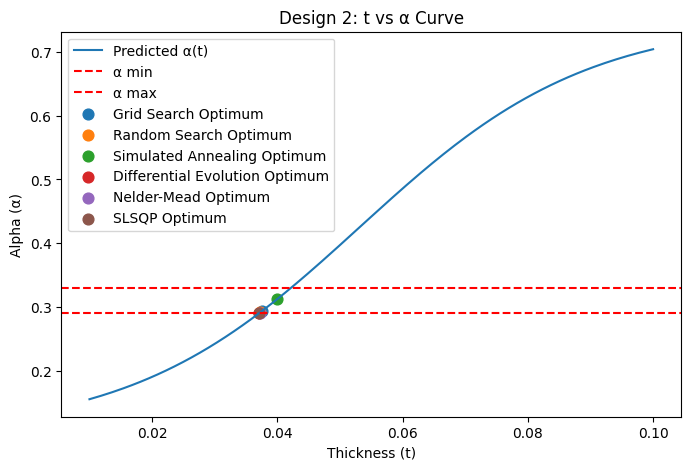

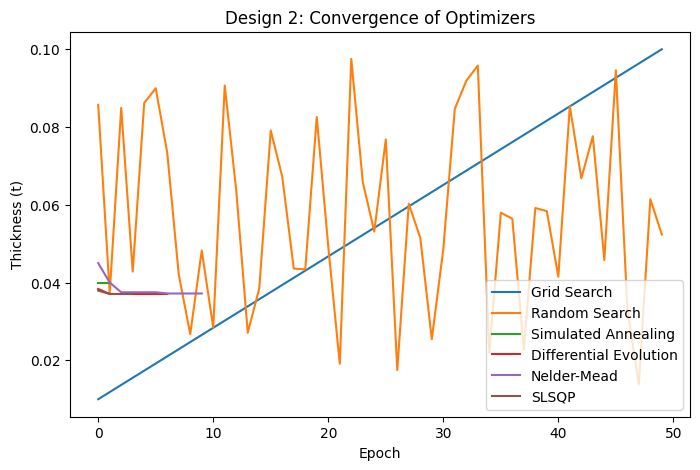


Design 3: n=32, Diameter=5.8, Density=18
Grid Search               | t = 0.043061 | α = 0.297420
Random Search             | t = 0.042914 | α = 0.296310
Simulated Annealing       | t = 0.042087 | α = 0.290135
Differential Evolution    | t = 0.042069 | α = 0.290001
Nelder-Mead               | t = 0.042188 | α = 0.290877
SLSQP                     | t = 0.042069 | α = 0.290000


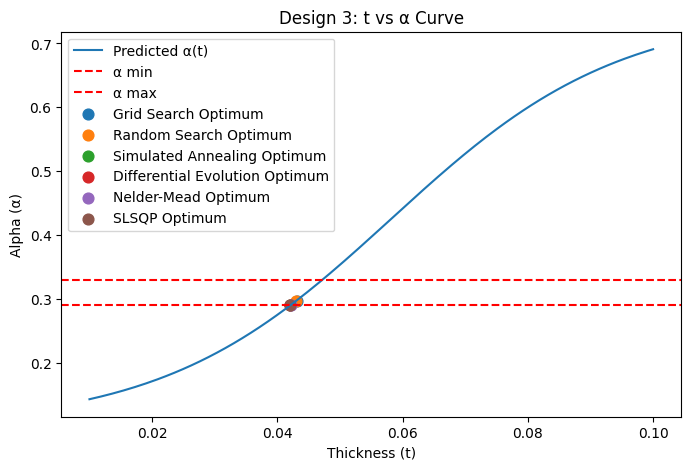

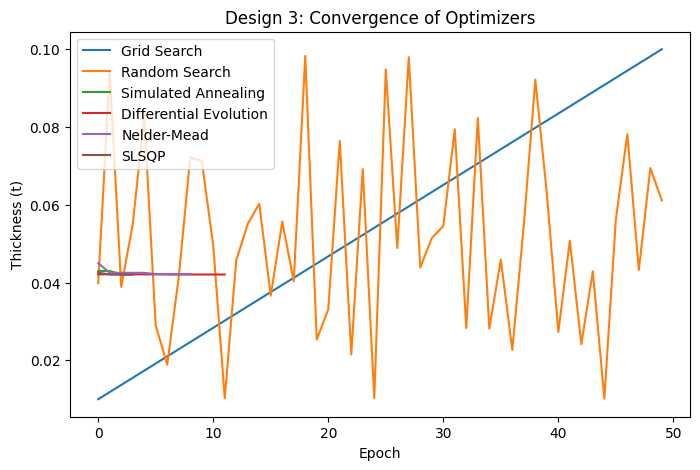

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import dual_annealing, differential_evolution, minimize

DATA_PATH = "Horizontal_Dataset-2.csv"
TH_MIN_GLOBAL = 0.01
TH_MAX_GLOBAL = 0.1
ALPHA_MIN = 0.29
ALPHA_MAX = 0.33
PENALTY = 1e6
EPOCHS = 50

a0, a1, a2, a3, a4, a5, a6 = -3.5, 5.5, 0.8, 0.4, 0.6, 0.3, 0.2
D_REF, RHO_REF, N_REF, BCON_REF, CON_REF = 10.0, 25.0, 40.0, 100.0, 50.0

data = pd.read_csv(DATA_PATH)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def predict_alpha(row, t):
    t = float(np.atleast_1d(t)[0])
    D, rho, n = row["Diameter (m)"], row["Density (kN/m³)"], row["n"]
    bcon = row.get("bcon", 50.0)
    con = row.get("con", 30.0)
    x = (a0 +
         a1 * (t / TH_MAX_GLOBAL) +
         a2 * (D / D_REF) +
         a3 * (rho / RHO_REF) -
         a4 * (n / N_REF) +
         a5 * (bcon / BCON_REF) -
         a6 * (con / CON_REF))
    alpha = 0.10 + 0.65 * sigmoid(x)
    return float(alpha)

def constraint_violation(t, alpha):
    if not (TH_MIN_GLOBAL <= t <= TH_MAX_GLOBAL):
        return PENALTY
    if alpha < ALPHA_MIN or alpha > ALPHA_MAX:
        return PENALTY + abs(alpha - 0.31) * 1e4
    return 0.0

def objective(t, row, use_excel_alpha=False):
    t = float(np.atleast_1d(t)[0])
    alpha = float(row["Alpha1"]) if use_excel_alpha else predict_alpha(row, t)
    penalty = constraint_violation(t, alpha)
    if penalty > 0:
        return penalty
    return t

def grid_search(row, steps=EPOCHS, use_excel_alpha=False, logs=None):
    t_values = np.linspace(TH_MIN_GLOBAL, TH_MAX_GLOBAL, steps)
    vals = [objective(t, row, use_excel_alpha) for t in t_values]
    if logs is not None:
        logs["Grid Search"] = list(zip(range(len(t_values)), t_values))
    return float(t_values[np.argmin(vals)])

def random_search(row, trials=EPOCHS, use_excel_alpha=False, logs=None):
    best_t, best_val = None, np.inf
    history = []
    for i in range(trials):
        t = np.random.uniform(TH_MIN_GLOBAL, TH_MAX_GLOBAL)
        val = objective(t, row, use_excel_alpha)
        history.append((i, t))
        if val < best_val:
            best_t, best_val = t, val
    if logs is not None:
        logs["Random Search"] = history
    return float(best_t)

def simulated_annealing(row, use_excel_alpha=False, logs=None):
    bounds = [(TH_MIN_GLOBAL, TH_MAX_GLOBAL)]
    history = []
    def callback(x, f, context):
        history.append((len(history), float(x[0])))
    res = dual_annealing(lambda x: objective(x, row, use_excel_alpha),
                         bounds=bounds, maxiter=EPOCHS, callback=callback)
    if logs is not None:
        logs["Simulated Annealing"] = history
    return float(res.x[0])

def diff_evo(row, use_excel_alpha=False, logs=None):
    bounds = [(TH_MIN_GLOBAL, TH_MAX_GLOBAL)]
    history = []
    def callback(xk, convergence):
        history.append((len(history), float(xk[0])))
    res = differential_evolution(lambda x: objective(x, row, use_excel_alpha),
                                 bounds=bounds, maxiter=EPOCHS,
                                 popsize=10, mutation=(0.5, 1.0),
                                 recombination=0.7, callback=callback)
    if logs is not None:
        logs["Differential Evolution"] = history
    return float(res.x[0])

def nelder_mead(row, use_excel_alpha=False, logs=None):
    x0 = np.array([0.05])
    history = []
    def callback(xk):
        history.append((len(history), float(xk[0])))
    res = minimize(lambda x: objective(x, row, use_excel_alpha),
                   x0, method="Nelder-Mead",
                   bounds=[(TH_MIN_GLOBAL, TH_MAX_GLOBAL)],
                   callback=callback, options={"maxiter": EPOCHS})
    if logs is not None:
        logs["Nelder-Mead"] = history
    return float(res.x[0])

def slsqp_refine(row, use_excel_alpha=False, logs=None):
    def cons_low(x): return (float(row["Alpha1"]) if use_excel_alpha else predict_alpha(row, x[0])) - ALPHA_MIN
    def cons_high(x): return ALPHA_MAX - (float(row["Alpha1"]) if use_excel_alpha else predict_alpha(row, x[0]))
    history = []
    def callback(xk): history.append((len(history), float(xk[0])))
    res = minimize(lambda x: x[0], np.array([0.05]), method="SLSQP",
                   bounds=[(TH_MIN_GLOBAL, TH_MAX_GLOBAL)],
                   constraints=[{"type": "ineq", "fun": cons_low},
                                {"type": "ineq", "fun": cons_high}],
                   callback=callback, options={"maxiter": EPOCHS})
    if logs is not None:
        logs["SLSQP"] = history
    return float(res.x[0])

METHODS = [
    ("Grid Search", grid_search),
    ("Random Search", random_search),
    ("Simulated Annealing", simulated_annealing),
    ("Differential Evolution", diff_evo),
    ("Nelder-Mead", nelder_mead),
    ("SLSQP", slsqp_refine)
]

if __name__ == "__main__":
    sample_rows = data.sample(3, random_state=42).reset_index(drop=True)
    for idx, row in sample_rows.iterrows():
        print("\n" + "=" * 60)
        print(f"Design {idx+1}: n={int(row['n'])}, Diameter={row['Diameter (m)']}, Density={row['Density (kN/m³)']}")
        logs = {}
        results = []
        for name, method in METHODS:
            try:
                t_opt = method(row, use_excel_alpha=False, logs=logs)
                alpha_opt = predict_alpha(row, t_opt)
                valid = ALPHA_MIN <= alpha_opt <= ALPHA_MAX
            except Exception:
                t_opt, alpha_opt, valid = None, None, False
            if valid:
                print(f"{name:<25} | t = {t_opt:.6f} | α = {alpha_opt:.6f}")
                results.append((name, t_opt, alpha_opt))
            else:
                print(f"{name:<25} | No feasible result")
        t_range = np.linspace(TH_MIN_GLOBAL, TH_MAX_GLOBAL, 200)
        alphas = [predict_alpha(row, t) for t in t_range]
        plt.figure(figsize=(8, 5))
        plt.plot(t_range, alphas, label="Predicted α(t)")
        plt.axhline(ALPHA_MIN, color="r", linestyle="--", label="α min")
        plt.axhline(ALPHA_MAX, color="r", linestyle="--", label="α max")
        for name, t_opt, a_opt in results:
            plt.scatter(t_opt, a_opt, label=f"{name} Optimum", s=60)
        plt.xlabel("Thickness (t)")
        plt.ylabel("Alpha (α)")
        plt.title(f"Design {idx+1}: t vs α Curve")
        plt.legend()
        plt.show()
        plt.figure(figsize=(8, 5))
        for name, hist in logs.items():
            if hist:
                iters, tvals = zip(*hist)
                plt.plot(iters, tvals, label=name)
        plt.xlabel("Epoch")
        plt.ylabel("Thickness (t)")
        plt.title(f"Design {idx+1}: Convergence of Optimizers")
        plt.legend()
        plt.show()



Design 1: n=36, Diameter=6.1, Density=18
Grid Search               | No feasible result
Random Search             | t̄ = 0.047526 | α = 0.327326
Simulated Annealing       | t̄ = 0.042790 | α = 0.290478
Differential Evolution    | t̄ = 0.042726 | α = 0.290006
Nelder-Mead               | No feasible result
SLSQP                     | t̄ = 0.042724 | α = 0.290000


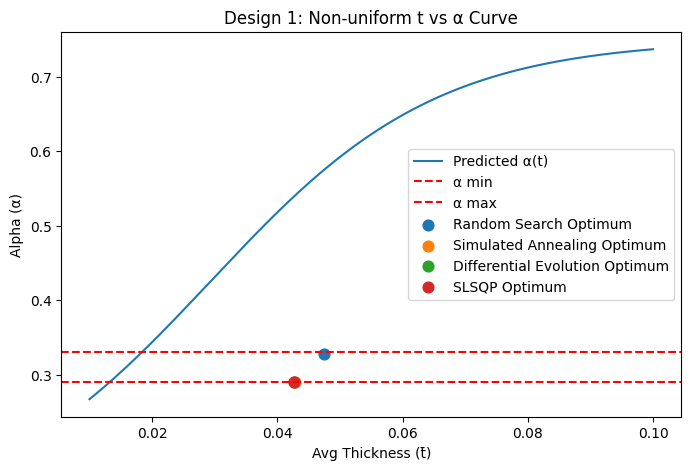

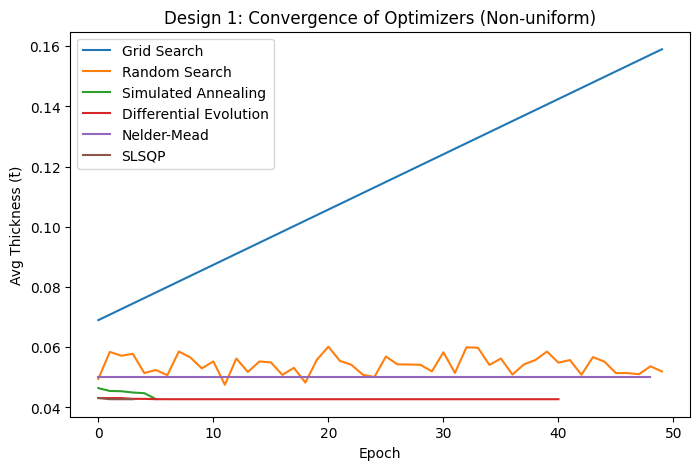


Design 2: n=40, Diameter=9.35, Density=25
Grid Search               | No feasible result
Random Search             | No feasible result
Simulated Annealing       | t̄ = 0.037371 | α = 0.292358
Differential Evolution    | No feasible result
Nelder-Mead               | No feasible result
SLSQP                     | t̄ = 0.037051 | α = 0.290000


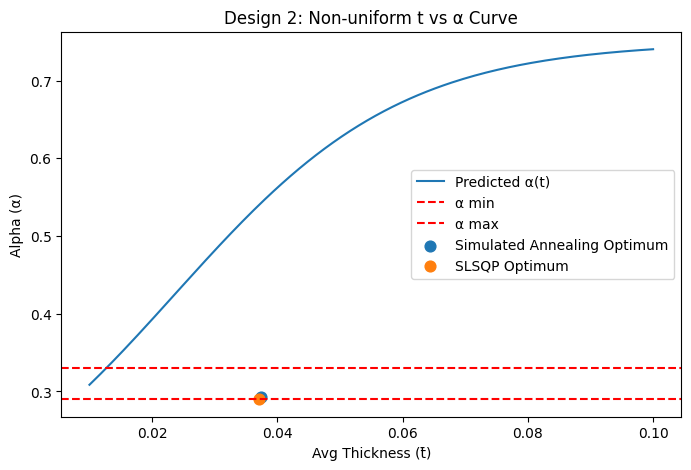

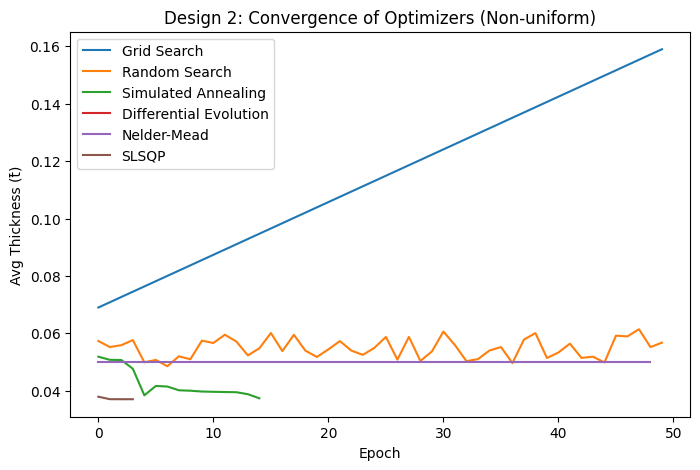


Design 3: n=32, Diameter=5.8, Density=18
Grid Search               | No feasible result
Random Search             | No feasible result
Simulated Annealing       | t̄ = 0.042143 | α = 0.290534
Differential Evolution    | t̄ = 0.042073 | α = 0.290016
Nelder-Mead               | No feasible result
SLSQP                     | t̄ = 0.042069 | α = 0.290000


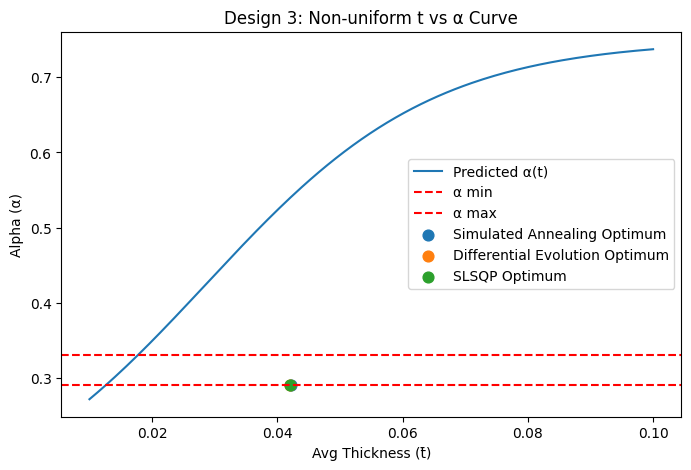

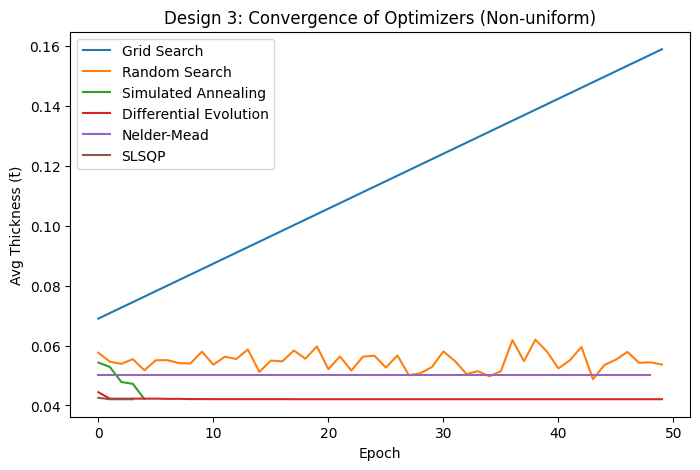

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import dual_annealing, differential_evolution, minimize

DATA_PATH = "Horizontal_Dataset_nonuniform.csv"
TH_MIN_GLOBAL = 0.01
TH_MAX_GLOBAL = 0.1
ALPHA_MIN = 0.29
ALPHA_MAX = 0.33
PENALTY = 1e6
EPOCHS = 50

a0, a1, a2, a3, a4, a5, a6 = -3.5, 5.5, 0.8, 0.4, 0.6, 0.3, 0.2
D_REF, RHO_REF, N_REF, BCON_REF, CON_REF = 10.0, 25.0, 40.0, 100.0, 50.0

data = pd.read_csv(DATA_PATH)
thickness_cols = [c for c in data.columns if "Thickness_" in c]

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def predict_alpha(row, t_list):
    D, rho, n = row["Diameter (m)"], row["Density (kN/m³)"], row["n"]
    bcon = row.get("bcon", 50.0)
    con = row.get("con", 30.0)
    t_mean = np.mean(t_list)
    var_term = np.var(t_list)
    x = (a0 +
         a1 * (t_mean / TH_MAX_GLOBAL) -
         0.2 * var_term +
         a2 * (D / D_REF) +
         a3 * (rho / RHO_REF) -
         a4 * (n / N_REF) +
         a5 * (bcon / BCON_REF) -
         a6 * (con / CON_REF))
    alpha = 0.10 + 0.65 * sigmoid(x)
    return float(alpha)

def objective(t_list, row):
    t_list = np.clip(np.array(t_list), TH_MIN_GLOBAL, TH_MAX_GLOBAL)
    alpha = predict_alpha(row, t_list)
    penalty = 0
    if np.any(t_list < TH_MIN_GLOBAL) or np.any(t_list > TH_MAX_GLOBAL):
        penalty += PENALTY
    if alpha < ALPHA_MIN or alpha > ALPHA_MAX:
        penalty += PENALTY + abs(alpha - 0.31) * 1e4
    return np.mean(t_list) + penalty

def grid_search(row, steps=EPOCHS, logs=None):
    best_val, best_t = np.inf, None
    history = []
    for t_val in np.linspace(TH_MIN_GLOBAL, TH_MAX_GLOBAL, steps):
        t_list = [t_val + (i * 0.002) for i in range(len(thickness_cols))]
        val = objective(t_list, row)
        history.append((len(history), np.mean(t_list)))
        if val < best_val:
            best_val, best_t = val, t_list
    if logs is not None:
        logs["Grid Search"] = history
    return np.array(best_t)

def random_search(row, trials=EPOCHS, logs=None):
    best_t, best_val = None, np.inf
    history = []
    for i in range(trials):
        t_list = np.random.uniform(TH_MIN_GLOBAL, TH_MAX_GLOBAL, len(thickness_cols))
        val = objective(t_list, row)
        history.append((i, np.mean(t_list)))
        if val < best_val:
            best_t, best_val = t_list, val
    if logs is not None:
        logs["Random Search"] = history
    return np.array(best_t)

def simulated_annealing(row, logs=None):
    bounds = [(TH_MIN_GLOBAL, TH_MAX_GLOBAL)] * len(thickness_cols)
    history = []
    def callback(x, f, context):
        history.append((len(history), np.mean(x)))
    res = dual_annealing(lambda x: objective(x, row),
                         bounds=bounds, maxiter=EPOCHS, callback=callback)
    if logs is not None:
        logs["Simulated Annealing"] = history
    return np.array(res.x)

def diff_evo(row, logs=None):
    bounds = [(TH_MIN_GLOBAL, TH_MAX_GLOBAL)] * len(thickness_cols)
    history = []
    def callback(xk, convergence):
        history.append((len(history), np.mean(xk)))
    res = differential_evolution(lambda x: objective(x, row),
                                 bounds=bounds, maxiter=EPOCHS,
                                 popsize=8, mutation=(0.5, 1.0),
                                 recombination=0.7, callback=callback)
    if logs is not None:
        logs["Differential Evolution"] = history
    return np.array(res.x)

def nelder_mead(row, logs=None):
    x0 = np.array([0.05] * len(thickness_cols))
    history = []
    def callback(xk):
        history.append((len(history), np.mean(xk)))
    res = minimize(lambda x: objective(x, row),
                   x0, method="Nelder-Mead",
                   callback=callback, options={"maxiter": EPOCHS})
    if logs is not None:
        logs["Nelder-Mead"] = history
    return np.array(res.x)

def slsqp_refine(row, logs=None):
    def cons_low(x): return predict_alpha(row, x) - ALPHA_MIN
    def cons_high(x): return ALPHA_MAX - predict_alpha(row, x)
    history = []
    def callback(xk): history.append((len(history), np.mean(xk)))
    res = minimize(lambda x: np.mean(x), np.array([0.05]*len(thickness_cols)), method="SLSQP",
                   bounds=[(TH_MIN_GLOBAL, TH_MAX_GLOBAL)]*len(thickness_cols),
                   constraints=[{"type": "ineq", "fun": cons_low},
                                {"type": "ineq", "fun": cons_high}],
                   callback=callback, options={"maxiter": EPOCHS})
    if logs is not None:
        logs["SLSQP"] = history
    return np.array(res.x)

METHODS = [
    ("Grid Search", grid_search),
    ("Random Search", random_search),
    ("Simulated Annealing", simulated_annealing),
    ("Differential Evolution", diff_evo),
    ("Nelder-Mead", nelder_mead),
    ("SLSQP", slsqp_refine)
]

if __name__ == "__main__":
    sample_rows = data.sample(3, random_state=42).reset_index(drop=True)
    for idx, row in sample_rows.iterrows():
        print("\n" + "=" * 60)
        print(f"Design {idx+1}: n={int(row['n'])}, Diameter={row['Diameter (m)']}, Density={row['Density (kN/m³)']}")
        logs = {}
        results = []
        for name, method in METHODS:
            try:
                t_opt_list = method(row, logs=logs)
                alpha_opt = predict_alpha(row, t_opt_list)
                valid = ALPHA_MIN <= alpha_opt <= ALPHA_MAX
            except Exception:
                t_opt_list, alpha_opt, valid = None, None, False
            if valid:
                print(f"{name:<25} | t̄ = {np.mean(t_opt_list):.6f} | α = {alpha_opt:.6f}")
                results.append((name, np.mean(t_opt_list), alpha_opt))
            else:
                print(f"{name:<25} | No feasible result")

        t_range = np.linspace(TH_MIN_GLOBAL, TH_MAX_GLOBAL, 200)
        alphas = [predict_alpha(row, [t + i*0.001 for i in range(len(thickness_cols))]) for t in t_range]
        plt.figure(figsize=(8, 5))
        plt.plot(t_range, alphas, label="Predicted α(t)")
        plt.axhline(ALPHA_MIN, color="r", linestyle="--", label="α min")
        plt.axhline(ALPHA_MAX, color="r", linestyle="--", label="α max")
        for name, t_opt, a_opt in results:
            plt.scatter(t_opt, a_opt, label=f"{name} Optimum", s=60)
        plt.xlabel("Avg Thickness (t̄)")
        plt.ylabel("Alpha (α)")
        plt.title(f"Design {idx+1}: Non-uniform t vs α Curve")
        plt.legend()
        plt.show()

        plt.figure(figsize=(8, 5))
        for name, hist in logs.items():
            if hist:
                iters, tvals = zip(*hist)
                plt.plot(iters, tvals, label=name)
        plt.xlabel("Epoch")
        plt.ylabel("Avg Thickness (t̄)")
        plt.title(f"Design {idx+1}: Convergence of Optimizers (Non-uniform)")
        plt.legend()
        plt.show()



Design 1: n=36, Diameter=6.1, Density=18
Grid Search               | t̄ = 0.069000 | α = 0.315465
Random Search             | t̄ = 0.049339 | α = 0.304910
Simulated Annealing       | t̄ = 0.010000 | α = 0.292557
Differential Evolution    | t̄ = 0.010000 | α = 0.292557
Nelder-Mead               | t̄ = 0.050000 | α = 0.305252
SLSQP                     | t̄ = 0.010000 | α = 0.292557


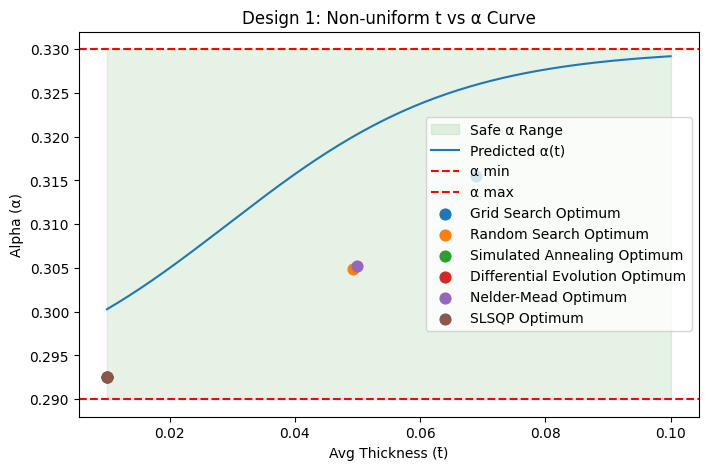

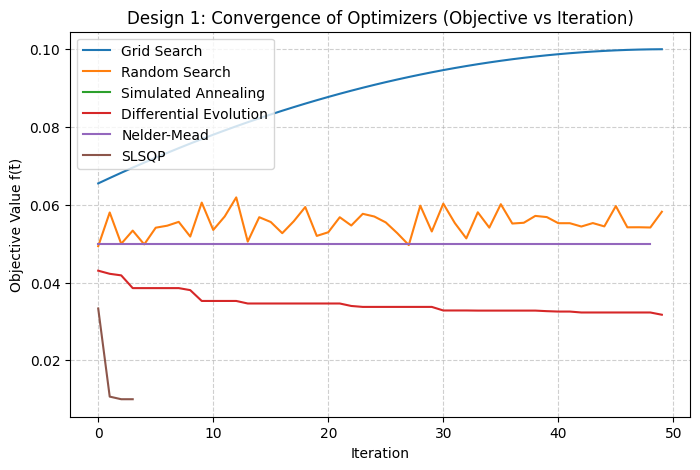


Design 2: n=40, Diameter=9.35, Density=25
Grid Search               | t̄ = 0.069000 | α = 0.318213
Random Search             | t̄ = 0.048426 | α = 0.307427
Simulated Annealing       | t̄ = 0.010000 | α = 0.293413
Differential Evolution    | t̄ = 0.010000 | α = 0.293413
Nelder-Mead               | t̄ = 0.050000 | α = 0.308284
SLSQP                     | t̄ = 0.010000 | α = 0.293413


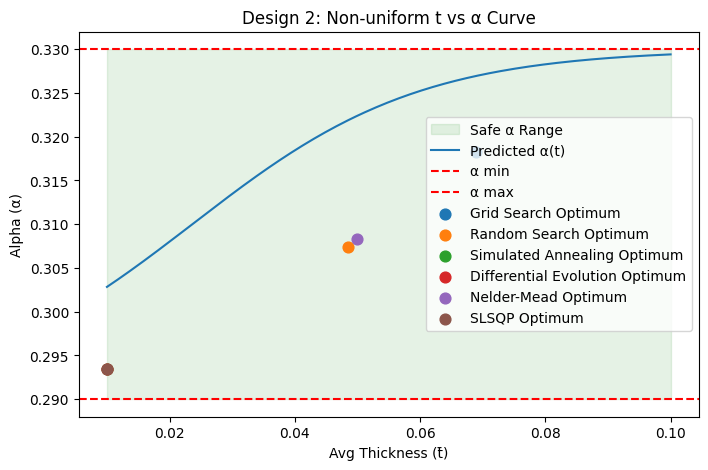

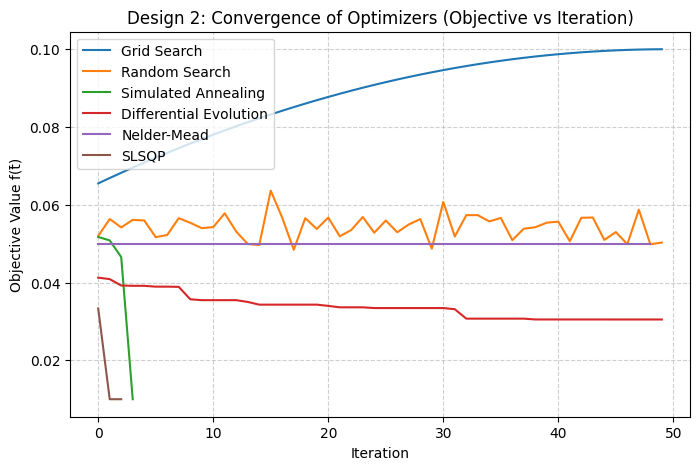


Design 3: n=32, Diameter=5.8, Density=18
Grid Search               | t̄ = 0.069000 | α = 0.315797
Random Search             | t̄ = 0.049036 | α = 0.305091
Simulated Annealing       | t̄ = 0.010000 | α = 0.292644
Differential Evolution    | t̄ = 0.010000 | α = 0.292644
Nelder-Mead               | t̄ = 0.050000 | α = 0.305593
SLSQP                     | t̄ = 0.010000 | α = 0.292644


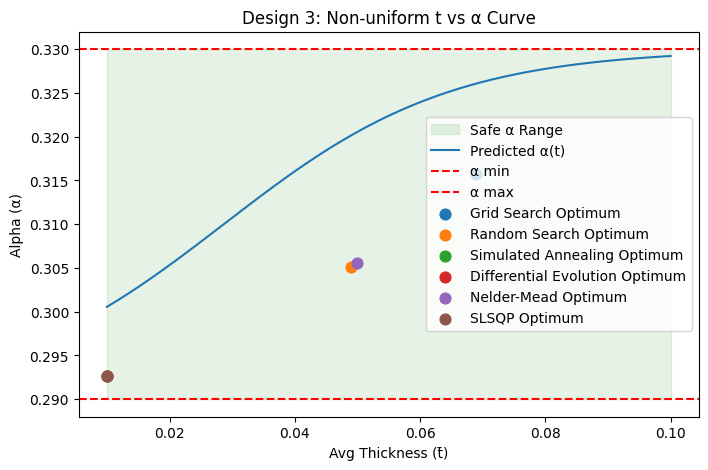

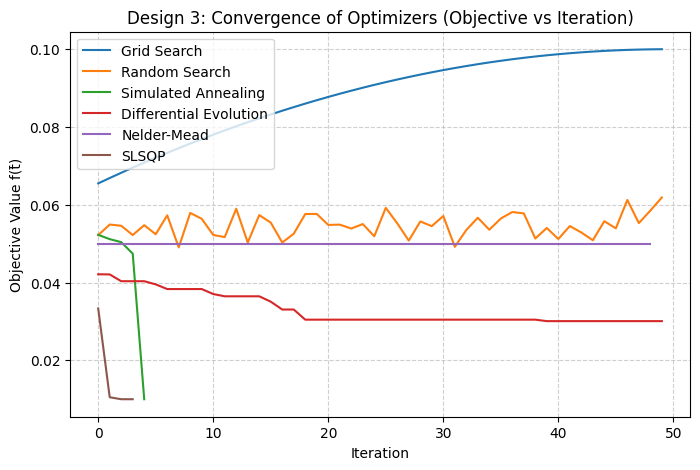

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import dual_annealing, differential_evolution, minimize

DATA_PATH = "Horizontal_Dataset_nonuniform.csv"
TH_MIN_GLOBAL = 0.01
TH_MAX_GLOBAL = 0.1
ALPHA_MIN = 0.29
ALPHA_MAX = 0.33
EPOCHS = 50
OBJECTIVE_FUNCTION = 1e6

a0, a1, a2, a3, a4, a5, a6 = -3.5, 5.5, 0.8, 0.4, 0.6, 0.3, 0.2
D_REF, RHO_REF, N_REF, BCON_REF, CON_REF = 10.0, 25.0, 40.0, 100.0, 50.0

data = pd.read_csv(DATA_PATH)
thickness_cols = [c for c in data.columns if "Thickness_" in c]

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def predict_alpha(row, t_list):
    D, rho, n = row["Diameter (m)"], row["Density (kN/m³)"], row["n"]
    bcon = row.get("bcon", 50.0)
    con = row.get("con", 30.0)
    t_mean = np.mean(t_list)
    var_term = np.var(t_list)
    x = (a0 + a1 * (t_mean / TH_MAX_GLOBAL) - 0.2 * var_term +
         a2 * (D / D_REF) + a3 * (rho / RHO_REF) -
         a4 * (n / N_REF) + a5 * (bcon / BCON_REF) -
         a6 * (con / CON_REF))
    alpha = 0.29 + 0.04 * sigmoid(x)
    return float(alpha)

def objective(t_list, row):
    t_list = np.clip(np.array(t_list), TH_MIN_GLOBAL, TH_MAX_GLOBAL)
    alpha = predict_alpha(row, t_list)
    penalty = 0
    if np.any(t_list < TH_MIN_GLOBAL) or np.any(t_list > TH_MAX_GLOBAL):
        penalty += OBJECTIVE_FUNCTION
    if alpha < ALPHA_MIN or alpha > ALPHA_MAX:
        penalty += OBJECTIVE_FUNCTION + abs(alpha - 0.31) * 1e4
    return np.mean(t_list) + penalty

def grid_search(row, steps=EPOCHS, logs=None):
    best_val, best_t = np.inf, None
    history = []
    for t_val in np.linspace(TH_MIN_GLOBAL, TH_MAX_GLOBAL, steps):
        t_list = [t_val + (i * 0.002) for i in range(len(thickness_cols))]
        val = objective(t_list, row)
        history.append((len(history), np.mean(t_list), val))
        if val < best_val:
            best_val, best_t = val, t_list
    if logs is not None:
        logs["Grid Search"] = history
    return np.array(best_t)

def random_search(row, trials=EPOCHS, logs=None):
    best_t, best_val = None, np.inf
    history = []
    for i in range(trials):
        t_list = np.random.uniform(TH_MIN_GLOBAL, TH_MAX_GLOBAL, len(thickness_cols))
        val = objective(t_list, row)
        history.append((i, np.mean(t_list), val))
        if val < best_val:
            best_t, best_val = t_list, val
    if logs is not None:
        logs["Random Search"] = history
    return np.array(best_t)

def simulated_annealing(row, logs=None):
    bounds = [(TH_MIN_GLOBAL, TH_MAX_GLOBAL)] * len(thickness_cols)
    history = []
    def callback(x, f, context):
        history.append((len(history), np.mean(x), f))
    res = dual_annealing(lambda x: objective(x, row), bounds=bounds, maxiter=EPOCHS, callback=callback)
    if logs is not None:
        logs["Simulated Annealing"] = history
    return np.array(res.x)

def diff_evo(row, logs=None):
    bounds = [(TH_MIN_GLOBAL, TH_MAX_GLOBAL)] * len(thickness_cols)
    history = []
    def callback(xk, convergence):
        fval = objective(xk, row)
        history.append((len(history), np.mean(xk), fval))
    res = differential_evolution(lambda x: objective(x, row), bounds=bounds, maxiter=EPOCHS,
                                 popsize=8, mutation=(0.5, 1.0), recombination=0.7, callback=callback)
    if logs is not None:
        logs["Differential Evolution"] = history
    return np.array(res.x)

def nelder_mead(row, logs=None):
    x0 = np.array([0.05] * len(thickness_cols))
    history = []
    def callback(xk):
        fval = objective(xk, row)
        history.append((len(history), np.mean(xk), fval))
    res = minimize(lambda x: objective(x, row), x0, method="Nelder-Mead",
                   callback=callback, options={"maxiter": EPOCHS})
    if logs is not None:
        logs["Nelder-Mead"] = history
    return np.array(res.x)

def slsqp_refine(row, logs=None):
    def cons_low(x): return predict_alpha(row, x) - ALPHA_MIN
    def cons_high(x): return ALPHA_MAX - predict_alpha(row, x)
    history = []
    def callback(xk):
        fval = objective(xk, row)
        history.append((len(history), np.mean(xk), fval))
    res = minimize(lambda x: np.mean(x), np.array([0.05]*len(thickness_cols)), method="SLSQP",
                   bounds=[(TH_MIN_GLOBAL, TH_MAX_GLOBAL)]*len(thickness_cols),
                   constraints=[{"type": "ineq", "fun": cons_low},
                                {"type": "ineq", "fun": cons_high}],
                   callback=callback, options={"maxiter": EPOCHS})
    if logs is not None:
        logs["SLSQP"] = history
    return np.array(res.x)

METHODS = [
    ("Grid Search", grid_search),
    ("Random Search", random_search),
    ("Simulated Annealing", simulated_annealing),
    ("Differential Evolution", diff_evo),
    ("Nelder-Mead", nelder_mead),
    ("SLSQP", slsqp_refine)
]

if __name__ == "__main__":
    sample_rows = data.sample(3, random_state=42).reset_index(drop=True)
    for idx, row in sample_rows.iterrows():
        print("\n" + "=" * 60)
        print(f"Design {idx+1}: n={int(row['n'])}, Diameter={row['Diameter (m)']}, Density={row['Density (kN/m³)']}")
        logs = {}
        results = []
        for name, method in METHODS:
            try:
                t_opt_list = method(row, logs=logs)
                alpha_opt = predict_alpha(row, t_opt_list)
                valid = ALPHA_MIN <= alpha_opt <= ALPHA_MAX
            except Exception:
                t_opt_list, alpha_opt, valid = None, None, False
            if valid:
                print(f"{name:<25} | t̄ = {np.mean(t_opt_list):.6f} | α = {alpha_opt:.6f}")
                results.append((name, np.mean(t_opt_list), alpha_opt))
            else:
                print(f"{name:<25} | No feasible result")

        t_range = np.linspace(TH_MIN_GLOBAL, TH_MAX_GLOBAL, 200)
        alphas = [predict_alpha(row, [t + i*0.001 for i in range(len(thickness_cols))]) for t in t_range]
        plt.figure(figsize=(8, 5))
        plt.fill_between(t_range, ALPHA_MIN, ALPHA_MAX, color='green', alpha=0.1, label="Safe α Range")
        plt.plot(t_range, alphas, label="Predicted α(t)")
        plt.axhline(ALPHA_MIN, color="r", linestyle="--", label="α min")
        plt.axhline(ALPHA_MAX, color="r", linestyle="--", label="α max")
        for name, t_opt, a_opt in results:
            plt.scatter(t_opt, a_opt, label=f"{name} Optimum", s=60)
        plt.xlabel("Avg Thickness (t̄)")
        plt.ylabel("Alpha (α)")
        plt.title(f"Design {idx+1}: Non-uniform t vs α Curve")
        plt.legend()
        plt.show()

        plt.figure(figsize=(8, 5))
        for name, hist in logs.items():
            if hist:
                iters, tvals, fvals = zip(*hist)
                plt.plot(iters, fvals, label=name)
        plt.xlabel("Iteration")
        plt.ylabel("Objective Value f(t̄)")
        plt.title(f"Design {idx+1}: Convergence of Optimizers (Objective vs Iteration)")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
